# Color extraction from face parts

In [1]:
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from faceparsing.parser import FaceParser
from imagine.shape.segment import ParsingSegmenter
from imagine.color import extract as color_extraction
from imagine.color.conversion import BgrToRgb
from sklearn.cluster import KMeans
from automakeup.face import extract as face_extraction, bounding
from mtcnn import MTCNN

In [2]:
parser = FaceParser()

In [3]:
parts_map = {
    "skin": 1,
    "hair": 2,
    "u_lip": 3,
    "l_lip": 3
}
segmenter = ParsingSegmenter(parser, parts_map=parts_map)

In [4]:
mtcnn = MTCNN()

In [5]:
face_extractor = face_extraction.SimpleFaceExtractor(512, interpolation=cv2.INTER_CUBIC)
bb_finder = bounding.MTCNNBoundingBoxFinder(mtcnn)

In [6]:
out_parts_map = {
    "face": 1,
    "hair": 2,
    "lips": 3
}

### Comparison of extraction methods

In [7]:
extractors = {
    "Mean": color_extraction.MeanColorExtractor(),
    "Median": color_extraction.MedianColorExtractor(),
    "MeanClustering\nwith KMeans with k=3": color_extraction.MeanClusteringColorExtractor(KMeans(n_clusters=3))
}

In [8]:
def show(image, segmented, extractors, parts_map, scale=3):
    scale = 3
    fig = plt.figure(figsize=(scale*(2 + len(parts_map)), scale*2))
    outer = gridspec.GridSpec(1, 2)
    
    ax = plt.Subplot(fig, outer[0])
    ax.imshow(image)
    ax.set_axis_off()
    fig.add_subplot(ax)
    
    extractors_grid = gridspec.GridSpecFromSubplotSpec(len(extractors), 1, subplot_spec=outer[1])

    for i, (name, extractor) in enumerate(extractors.items()):
        
        ax = plt.Subplot(fig, extractors_grid[i])
        ax.set_ylabel(name)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_frame_on(False)
        fig.add_subplot(ax)
        
        colors_grid = gridspec.GridSpecFromSubplotSpec(1, len(parts_map), subplot_spec=extractors_grid[i])
        
        colors = {part: extractor.extract(image, segmented == parts_map[part]) for part in parts_map}
        
        for j, (part, color) in enumerate(colors.items()):
            ax = plt.Subplot(fig, colors_grid[j])
            ax.imshow(color.reshape((1,1,3)))
            if i == 0:
                ax.title.set_text(part)
            ax.set_axis_off()
            fig.add_subplot(ax)

    plt.tight_layout()
    plt.show()

In [9]:
image_paths = ["faces/" + f for f in os.listdir("faces")]

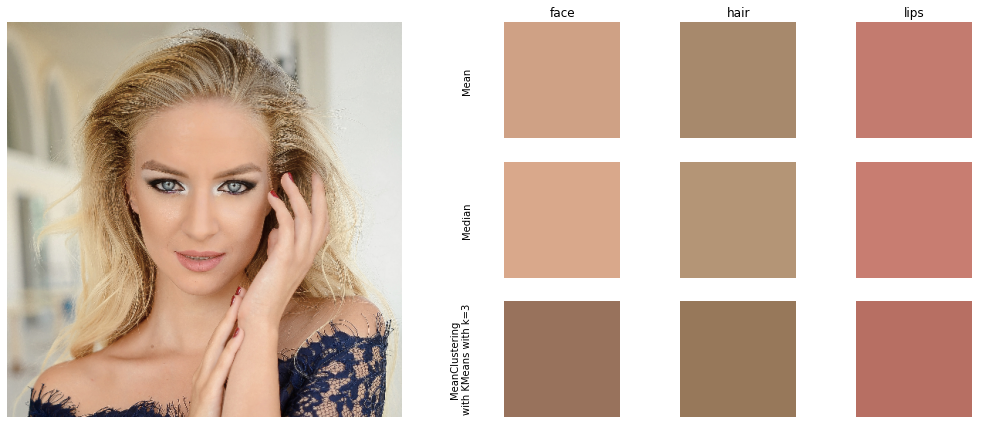

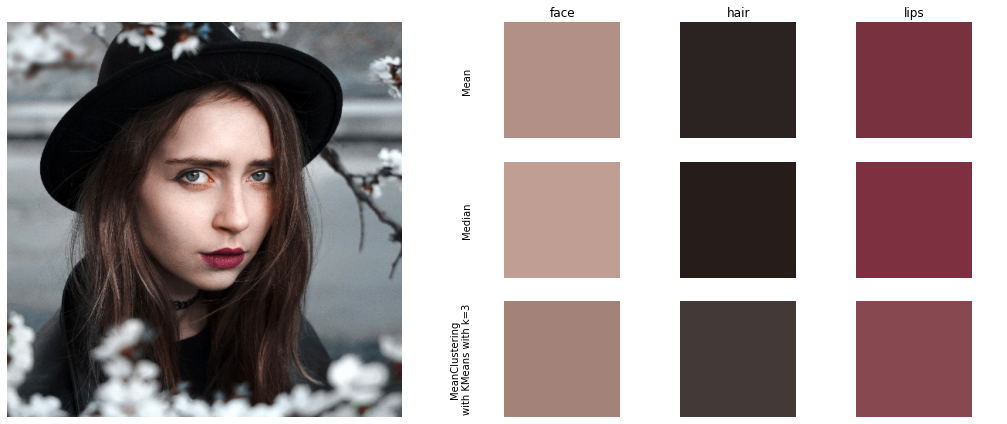

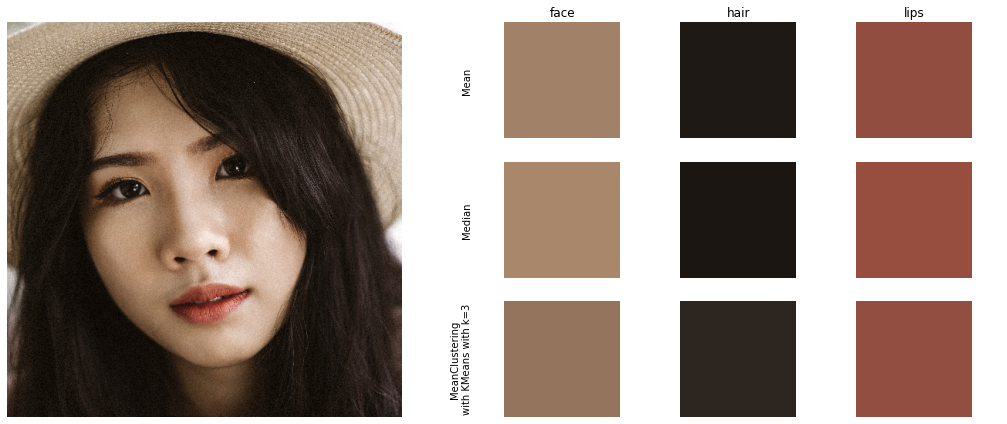

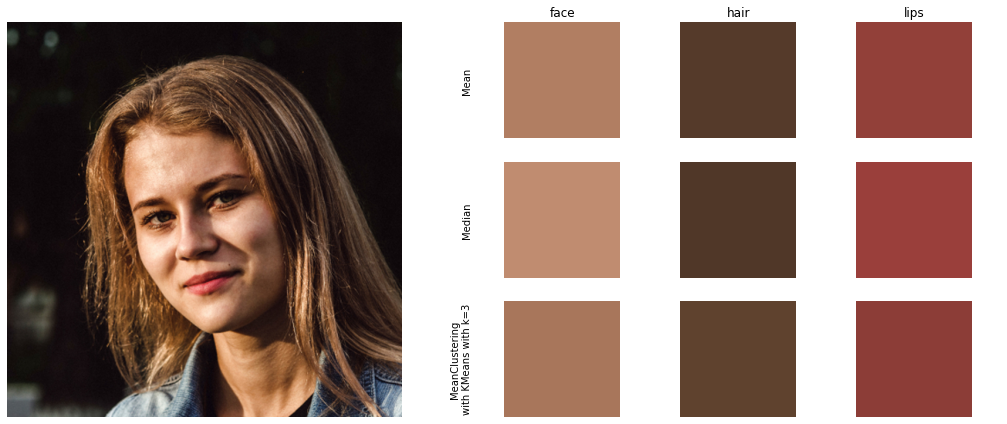

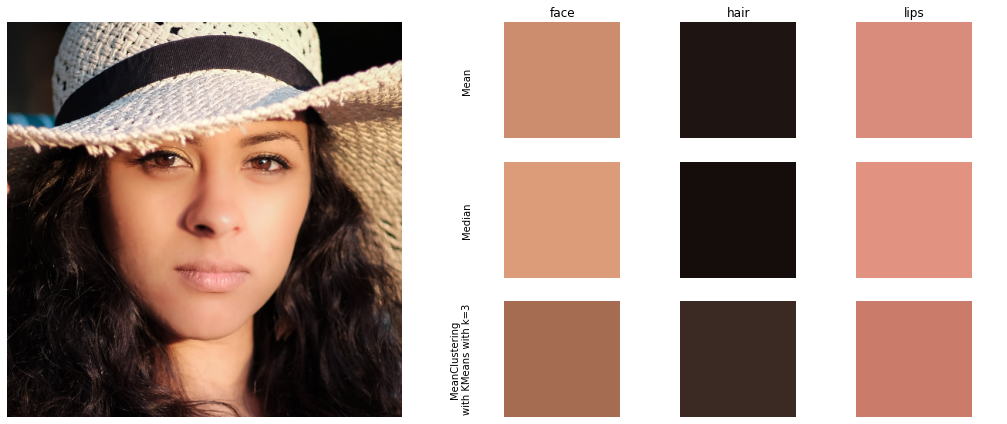

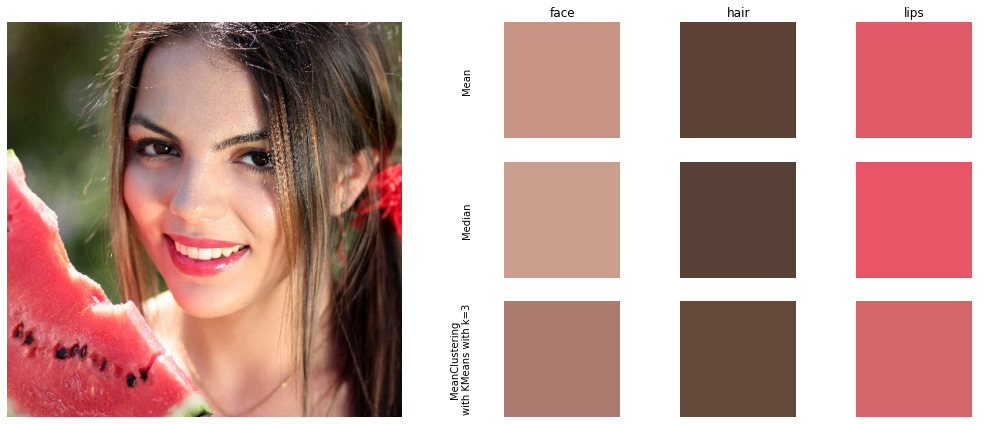

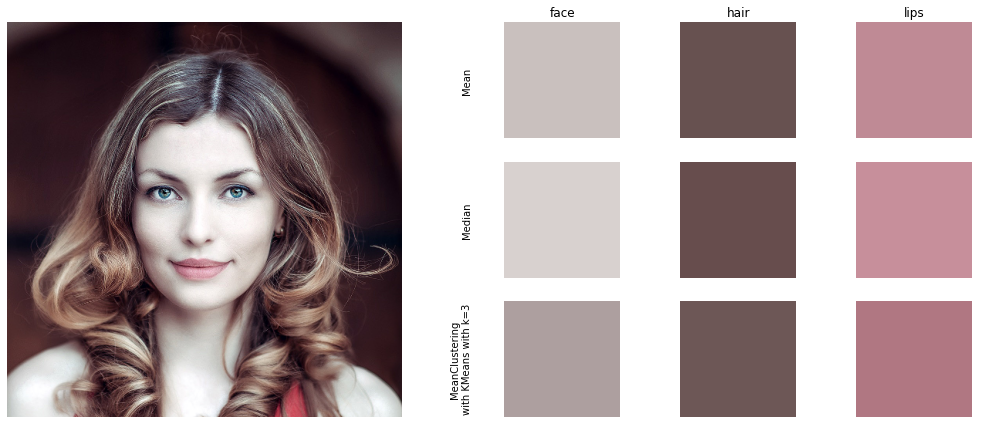

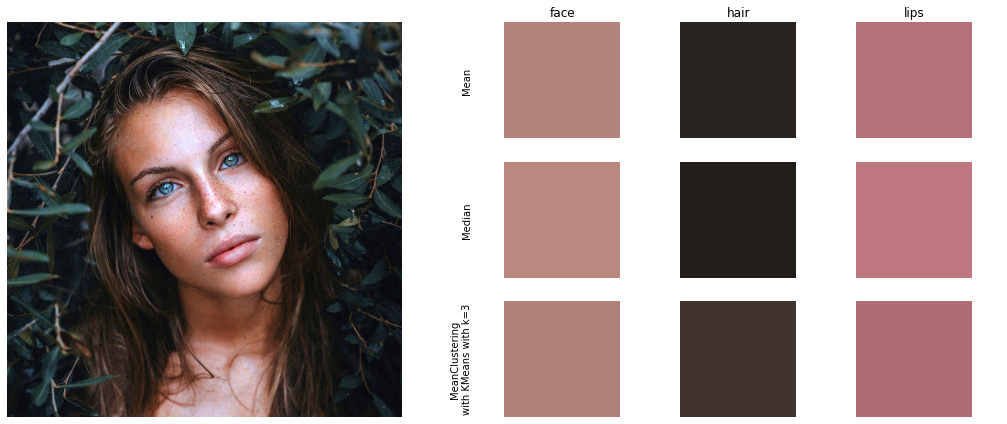

In [10]:
for path in image_paths:
    image = BgrToRgb(cv2.imread(path))
    bb = bb_finder.find(image)
    image = face_extractor.extract(image, bb)
    segmented = segmenter(image)
    show(image, segmented, extractors, out_parts_map)